<a href="https://www.kaggle.com/code/keilamoral/avast-ctu-cape?scriptVersionId=223261587" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# Avast-CTU Public CAPEv2 Dataset

There is a limited amount of publicly available data to support research in malware analysis technology. Particularly, there are virtually no publicly available datasets generated from rich sandboxes such as Cuckoo/CAPE.

The benefit of using dynamic sandboxes is the realistic simulation of file execution in the target machine and obtaining a log of such execution. The machine can be infected by malware hence there is a good chance of capturing the malicious behavior in the execution logs,  thus allowing researchers to study such behavior in detail. Although the subsequent analysis of log information is extensively covered in industrial cybersecurity backends, to our knowledge there has been only limited effort invested in academia to advance such log analysis capabilities using cutting edge techniques. 

We make this sample dataset available to support designing new machine learning methods for malware detection, especially for automatic detection of generic malicious behavior. The dataset has been collected in cooperation between Avast Software and Czech Technical University - AI Center (AIC).
​
The archive contains CAPEv2 reports of 48,976 malicious files. For each file, we provide the following metadata:
* sha256,
* classification to malware family,
* type of the malware,
* date of detection of the file.
  
There are 6 types of malware ( "banker", "trojan", "pws", "coinminer", "rat", "keylogger") and 10 malware families in the dataset:
​
| Malware Family Name | Number of Samples |
| ------------------- | ----------------- |
| Adload              | 704               |
| Emotet              | 14,429            |
| HarHar              | 655               |
| Lokibot             | 4,191             |
| njRAT               | 3,372             |
| Qakbot              | 4,895             |
| Swisyn              | 12,591            |
| Trickbot            | 4,202             |
| Ursnif              | 1,343             |
| Zeus                | 2,594             |


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.utils.class_weight import compute_class_weight
import os


In [2]:
# Loading dataset
avast_ctu_dataset = pd.read_csv('/kaggle/input/avast-ctu-dataset/public_labels.csv')

# Modifying dataset
family_type_mapping = {
    0: 'Adload', 1: 'Emotet', 2: 'HarHar', 3: 'Lokibot', 4: 'njRAT',
    5: 'Qakbot', 6: 'Swisyn', 7: 'Trickbot', 8: 'Ursnif', 9: 'Zeus'
}

malware_type_mapping = {
    0: 'banker', 1: 'trojan', 2: 'pws', 3: 'coinminer', 4: 'rat',
    5: 'keylogger'
}
avast_ctu_dataset.head()
avast_ctu_dataset['date'] = pd.to_datetime(avast_ctu_dataset['date'])
avast_ctu_dataset = avast_ctu_dataset.sort_values(by='date')
avast_ctu_dataset.head()
print(type(avast_ctu_dataset['date']))

<class 'pandas.core.series.Series'>


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


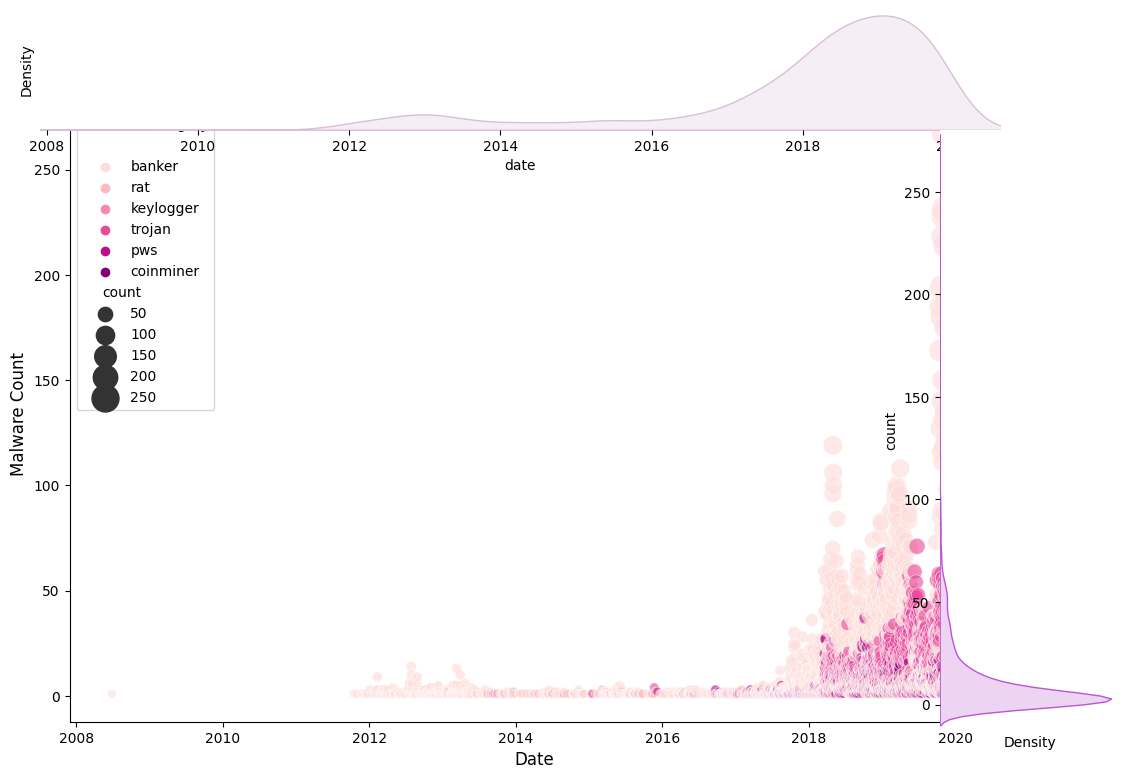

In [3]:
# Plot the malware types over time
def plot_malware_frequency(df):

    # Aggregate malware counts by date and type
    malware_counts = df.groupby(['date', 'classification_type']).size().reset_index(name='count')

    # Create the main plot
    f, ax = plt.subplots(figsize=(12, 8))
    
    # Create additional axes for the distributions
    ax_histx = plt.axes([0.1, 0.85, 0.8, 0.15])
    ax_histy = plt.axes([0.85, 0.1, 0.15, 0.75])

    # Remove unnecessary spines
    sns.despine(f)
    sns.despine(ax=ax_histx, left=True, bottom=True)
    sns.despine(ax=ax_histy, left=True, bottom=True)

    pink_palette = sns.color_palette("RdPu", n_colors=len(df['classification_type'].unique()))

    # Main scatter plot
    sns.scatterplot(x="date", y="count",
                    hue="classification_type",
                    size="count",
                    sizes=(40, 400),
                    alpha=0.6,
                    data=malware_counts,
                    palette=pink_palette,
                    ax=ax)

    # KDE plot for x-axis (dates)
    sns.kdeplot(data=malware_counts, x="date", ax=ax_histx, color='thistle', fill=True)
    ax_histx.set_xlim(ax.get_xlim())
    ax_histx.set_yticks([])

    # KDE plot for y-axis (counts)
    sns.kdeplot(data=malware_counts, y="count", ax=ax_histy, color='mediumorchid', fill=True)
    ax_histy.set_ylim(ax.get_ylim())
    ax_histy.set_xticks([])

    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Malware Count", fontsize=12)
    ax.set_title("Frequency of Malware Types Over Time", fontsize=14)

    plt.xticks(rotation=45, ha="right")

    # Sub
    leg = ax.get_legend()
    leg.set_title("Malware Category")
    for t in leg.texts:
        if t.get_text() == 'classification_type':
            t.set_text('')
    
    #plt.tight_layout()
    plt.show()

# Assuming avast_ctu_dataset is your DataFrame
plot_malware_frequency(avast_ctu_dataset)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


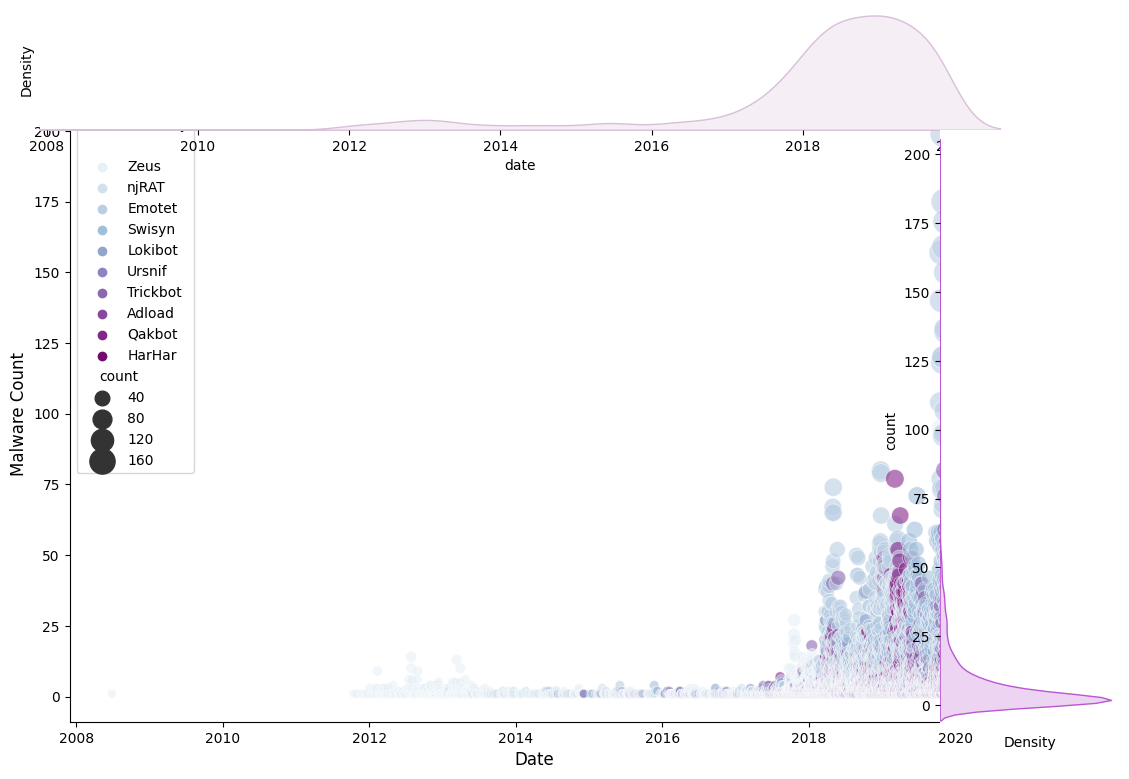

In [4]:
# Plot the malware types over time
def plot_malware_frequency(df):

    # Aggregate malware counts by date and type
    malware_counts = df.groupby(['date', 'classification_family']).size().reset_index(name='count')

    # Create the main plot
    f, ax = plt.subplots(figsize=(12, 8))
    
    # Create additional axes for the distributions
    ax_histx = plt.axes([0.1, 0.85, 0.8, 0.15])
    ax_histy = plt.axes([0.85, 0.1, 0.15, 0.75])

    # Remove unnecessary spines
    sns.despine(f)
    sns.despine(ax=ax_histx, left=True, bottom=True)
    sns.despine(ax=ax_histy, left=True, bottom=True)

    pink_palette = sns.color_palette("BuPu", n_colors=len(df['classification_family'].unique()))

    # Main scatter plot
    sns.scatterplot(x="date", y="count",
                    hue="classification_family",
                    size="count",
                    sizes=(40, 400),
                    alpha=0.6,
                    data=malware_counts,
                    palette=pink_palette,
                    ax=ax)

    # KDE plot for x-axis (dates)
    sns.kdeplot(data=malware_counts, x="date", ax=ax_histx, color='thistle', fill=True)
    ax_histx.set_xlim(ax.get_xlim())
    ax_histx.set_yticks([])

    # KDE plot for y-axis (counts)
    sns.kdeplot(data=malware_counts, y="count", ax=ax_histy, color='mediumorchid', fill=True)
    ax_histy.set_ylim(ax.get_ylim())
    ax_histy.set_xticks([])

    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Malware Count", fontsize=12)
    ax.set_title("Frequency of Malware Families Over Time", fontsize=14)

    plt.xticks(rotation=45, ha="right")

    # Sub
    leg = ax.get_legend()
    leg.set_title("Malware family")
    for t in leg.texts:
        if t.get_text() == 'classification_family':
            t.set_text('')
    
    #plt.tight_layout()
    plt.show()

# Assuming avast_ctu_dataset is your DataFrame
plot_malware_frequency(avast_ctu_dataset)

In [5]:
# Convert date to string
avast_ctu_dataset['date'] = avast_ctu_dataset['date'].astype(str)

# Prepare the features
# Use HashingVectorizer for sha256 to convert it to numeric features
hv = HashingVectorizer(n_features=20)
sha256_features = hv.fit_transform(avast_ctu_dataset['sha256']).toarray()

# Encode classification_type
le_type = LabelEncoder()
type_encoded = le_type.fit_transform(avast_ctu_dataset['classification_type'])

# Convert date to numeric and extract additional features
date_numeric = pd.to_datetime(avast_ctu_dataset['date'])
date_features = np.column_stack((
    date_numeric.astype(int) / 10**9,
    date_numeric.dt.year,
    date_numeric.dt.month,
    date_numeric.dt.day,
    date_numeric.dt.dayofweek
))

# Combine all features
X = np.hstack((sha256_features, date_features, type_encoded.reshape(-1, 1)))

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prepare the target
y = avast_ctu_dataset['classification_family']

# Encode the target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to one-hot encoding
y_onehot = tf.keras.utils.to_categorical(y_encoded)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)


In [6]:
# Define the first model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_scaled.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_split=0.2, verbose=1, 
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3437 - loss: 1.9580 - val_accuracy: 0.6303 - val_loss: 1.0286 - learning_rate: 0.0010
Epoch 2/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6297 - loss: 1.0601 - val_accuracy: 0.6899 - val_loss: 0.8535 - learning_rate: 0.0010
Epoch 3/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6720 - loss: 0.9185 - val_accuracy: 0.7162 - val_loss: 0.7810 - learning_rate: 0.0010
Epoch 4/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6940 - loss: 0.8436 - val_accuracy: 0.7167 - val_loss: 0.7409 - learning_rate: 0.0010
Epoch 5/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7058 - loss: 0.7974 - val_accuracy: 0.7263 - val_loss: 0.7115 - learning_rate: 0.0010
Epoch 6/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7167 - loss: 0.7585 - val_accuracy: 0.7302 - val_loss: 0.6971 - learning_rate: 0.0010
Epoch 7/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7214 - loss: 0.

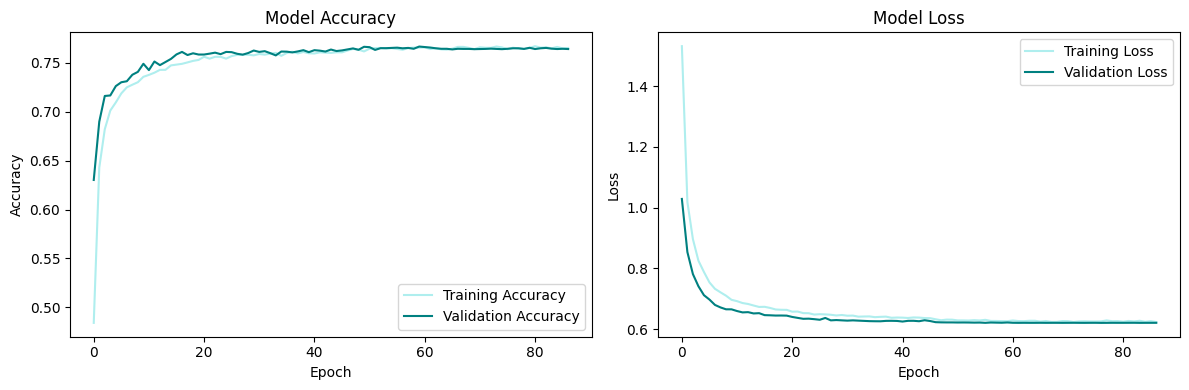

307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


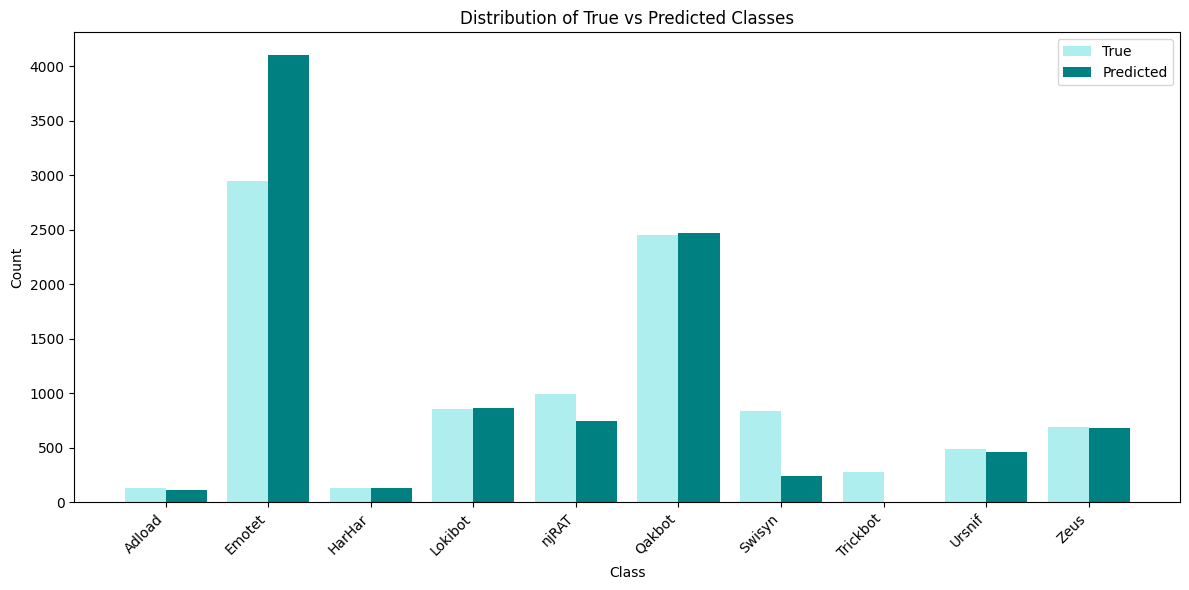

              precision    recall  f1-score   support

      Adload       0.60      0.49      0.54       134
      Emotet       0.63      0.88      0.74      2949
      HarHar       0.98      1.00      0.99       127
     Lokibot       0.99      1.00      1.00       858
      Qakbot       0.49      0.36      0.42       991
      Swisyn       0.97      0.98      0.98      2448
    Trickbot       0.74      0.21      0.33       837
      Ursnif       0.00      0.00      0.00       277
        Zeus       0.65      0.61      0.63       488
       njRAT       1.00      0.99      0.99       687

    accuracy                           0.77      9796
   macro avg       0.71      0.65      0.66      9796
weighted avg       0.76      0.77      0.74      9796



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='paleturquoise', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='teal', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='paleturquoise', label='Training Loss')
plt.plot(history.history['val_loss'], color='teal', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot histogram of testing categories
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

plt.figure(figsize=(12, 6))
plt.hist([y_true_classes, y_pred_classes], label=['True', 'Predicted'],
         color=['paleturquoise', 'teal'],
         bins=range(y_onehot.shape[1] + 1), align='left', rwidth=0.8)

plt.title('Distribution of True vs Predicted Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
tick_locations = np.arange(len(family_type_mapping))
tick_labels = [family_type_mapping[tick] for tick in tick_locations]
plt.xticks(tick_locations, tick_labels, rotation=45, ha='right')
plt.tight_layout()

plt.show()

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

In [8]:
# Second model (trying to improve previous one)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_scaled.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Define callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

def augment_date(date_features):
    noise = np.random.normal(0, 0.1, date_features.shape)
    return date_features + noise

X_train_augmented = np.hstack((
    X_train[:, :20],  # sha256 features
    augment_date(X_train[:, 20:-1]),  # date features
    X_train[:, -1].reshape(-1, 1)  # type_encoded
))
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(class_weights))

history = model.fit(X_train_augmented, y_train, epochs=150, batch_size=32, 
                    validation_split=0.2, verbose=1, 
                    callbacks=[early_stopping, reduce_lr],
                    class_weight=class_weight_dict)


Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


980/980 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2162 - loss: 2.2192 - val_accuracy: 0.4857 - val_loss: 1.2112 - learning_rate: 0.0010
Epoch 2/150
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3900 - loss: 1.3593 - val_accuracy: 0.5257 - val_loss: 1.0515 - learning_rate: 0.0010
Epoch 3/150
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4198 - loss: 1.1963 - val_accuracy: 0.5282 - val_loss: 1.0066 - learning_rate: 0.0010
Epoch 4/150
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4470 - loss: 1.0661 - val_accuracy: 0.5897 - val_loss: 0.9433 - learning_rate: 0.0010
Epoch 5/150
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4817 - loss: 0.9983 - val_accuracy: 0.5172 - val_loss: 0.9933 - learning_rate: 0.0010
Epoch 6/150
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4996 - loss: 0.9195 - val_accuracy: 0.5528 - val_loss: 0.9503 - learning_rate: 0.0010
Epoch 7/150
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5232 - loss: 0.8799 - val_a